In [38]:
import pickle
import numpy as np
import torch
from utils import *
from tqdm.notebook import trange, tqdm
import random
import json
import seaborn as sns
from sklearn.metrics import top_k_accuracy_score, confusion_matrix
import pandas as pd

In [39]:
# Load Test Data

image_embeddings = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/image_embeddings.pt").cpu()
labels = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/labels.pt").cpu()


In [40]:
inds = np.array(random.choices(range(50000), k=10000))

small_ie = image_embeddings[inds]
small_labels = labels[inds]
print(small_ie.shape, small_labels.shape)

torch.Size([10000, 1024]) torch.Size([10000])


In [41]:
# Load Model

clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

In [42]:
from classes import CLASSES, GENERIC_PROMPT_COLLECTIONS
import torch.nn as nn
from clip import clip
import os
import torch


# Initialize CLIP models 
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype
        self.token_embedding = clip_model.token_embedding

    def forward(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

def load_clip_to_cpu(visual_backbone):
    backbone_name = visual_backbone
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url, os.path.expanduser("~/.cache/clip"))

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())

    return model

clip_model = load_clip_to_cpu("RN50")

visual_model = torch.nn.DataParallel(clip_model.visual).cuda()

text_model = TextEncoder(clip_model)
text_model = torch.nn.DataParallel(text_model).cuda()

In [43]:
all_labels_text = {}
text_embs = []
text_labels = []
with torch.no_grad():
    for label in tqdm(range(1000)):
        all_labels_text[label] = []

        templates = ["a photo of a {}."]
        c = np.array(CLASSES)[label]
            
        texts = clip.tokenize([template.format(c) for template in templates]) 
        texts = texts.cuda()
        zeroshot_weights = clip_model.encode_text(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )
        all_labels_text[label].append(zeroshot_weights)
        text_embs.append(zeroshot_weights)
        for i in range(len(templates)):
            text_labels.append(label)
        
text_embs = torch.cat(text_embs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [44]:
# syn_labels_text = {}
# text_embs = []
# text_labels = []
# with torch.no_grad():
#     for label in tqdm(range(1000)):
#         all_labels_text[label] = []

#         templates = ["a photo of a {}."]
#         c = np.array(CLASSES)[label]
            
#         texts = clip.tokenize([template.format(c) for template in templates]) 
#         texts = texts.cuda()
#         zeroshot_weights = clip_model.encode_text(texts).float()
#         zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
#             dim=-1, keepdim=True
#         )
#         all_labels_text[label].append(zeroshot_weights)
#         text_embs.append(zeroshot_weights)
#         for i in range(len(templates)):
#             text_labels.append(label)
        
# text_embs = torch.cat(text_embs)

In [45]:
text_embs.shape

torch.Size([1000, 1024])

In [46]:
# Class frequencies

freqs = json.load(open("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/class_frequencies.json"))
freqs = {int(k):v for k,v in freqs.items()}

### Image only Eval

In [47]:
predictions_all = clf.predict(image_embeddings)
avg_acc = mic_acc_cal(predictions_all, labels.numpy())
avg_acc

0.62202

In [48]:
predictions = clf.predict(small_ie)
avg_acc = mic_acc_cal(predictions, small_labels.numpy())
avg_acc

0.6294

### Text bias?

In [49]:
preds_text_proba = clf.predict_proba(text_embs.cpu())
preds_text = clf.predict(text_embs.cpu())

In [50]:
plt.rcParams["figure.figsize"] = (30,30)

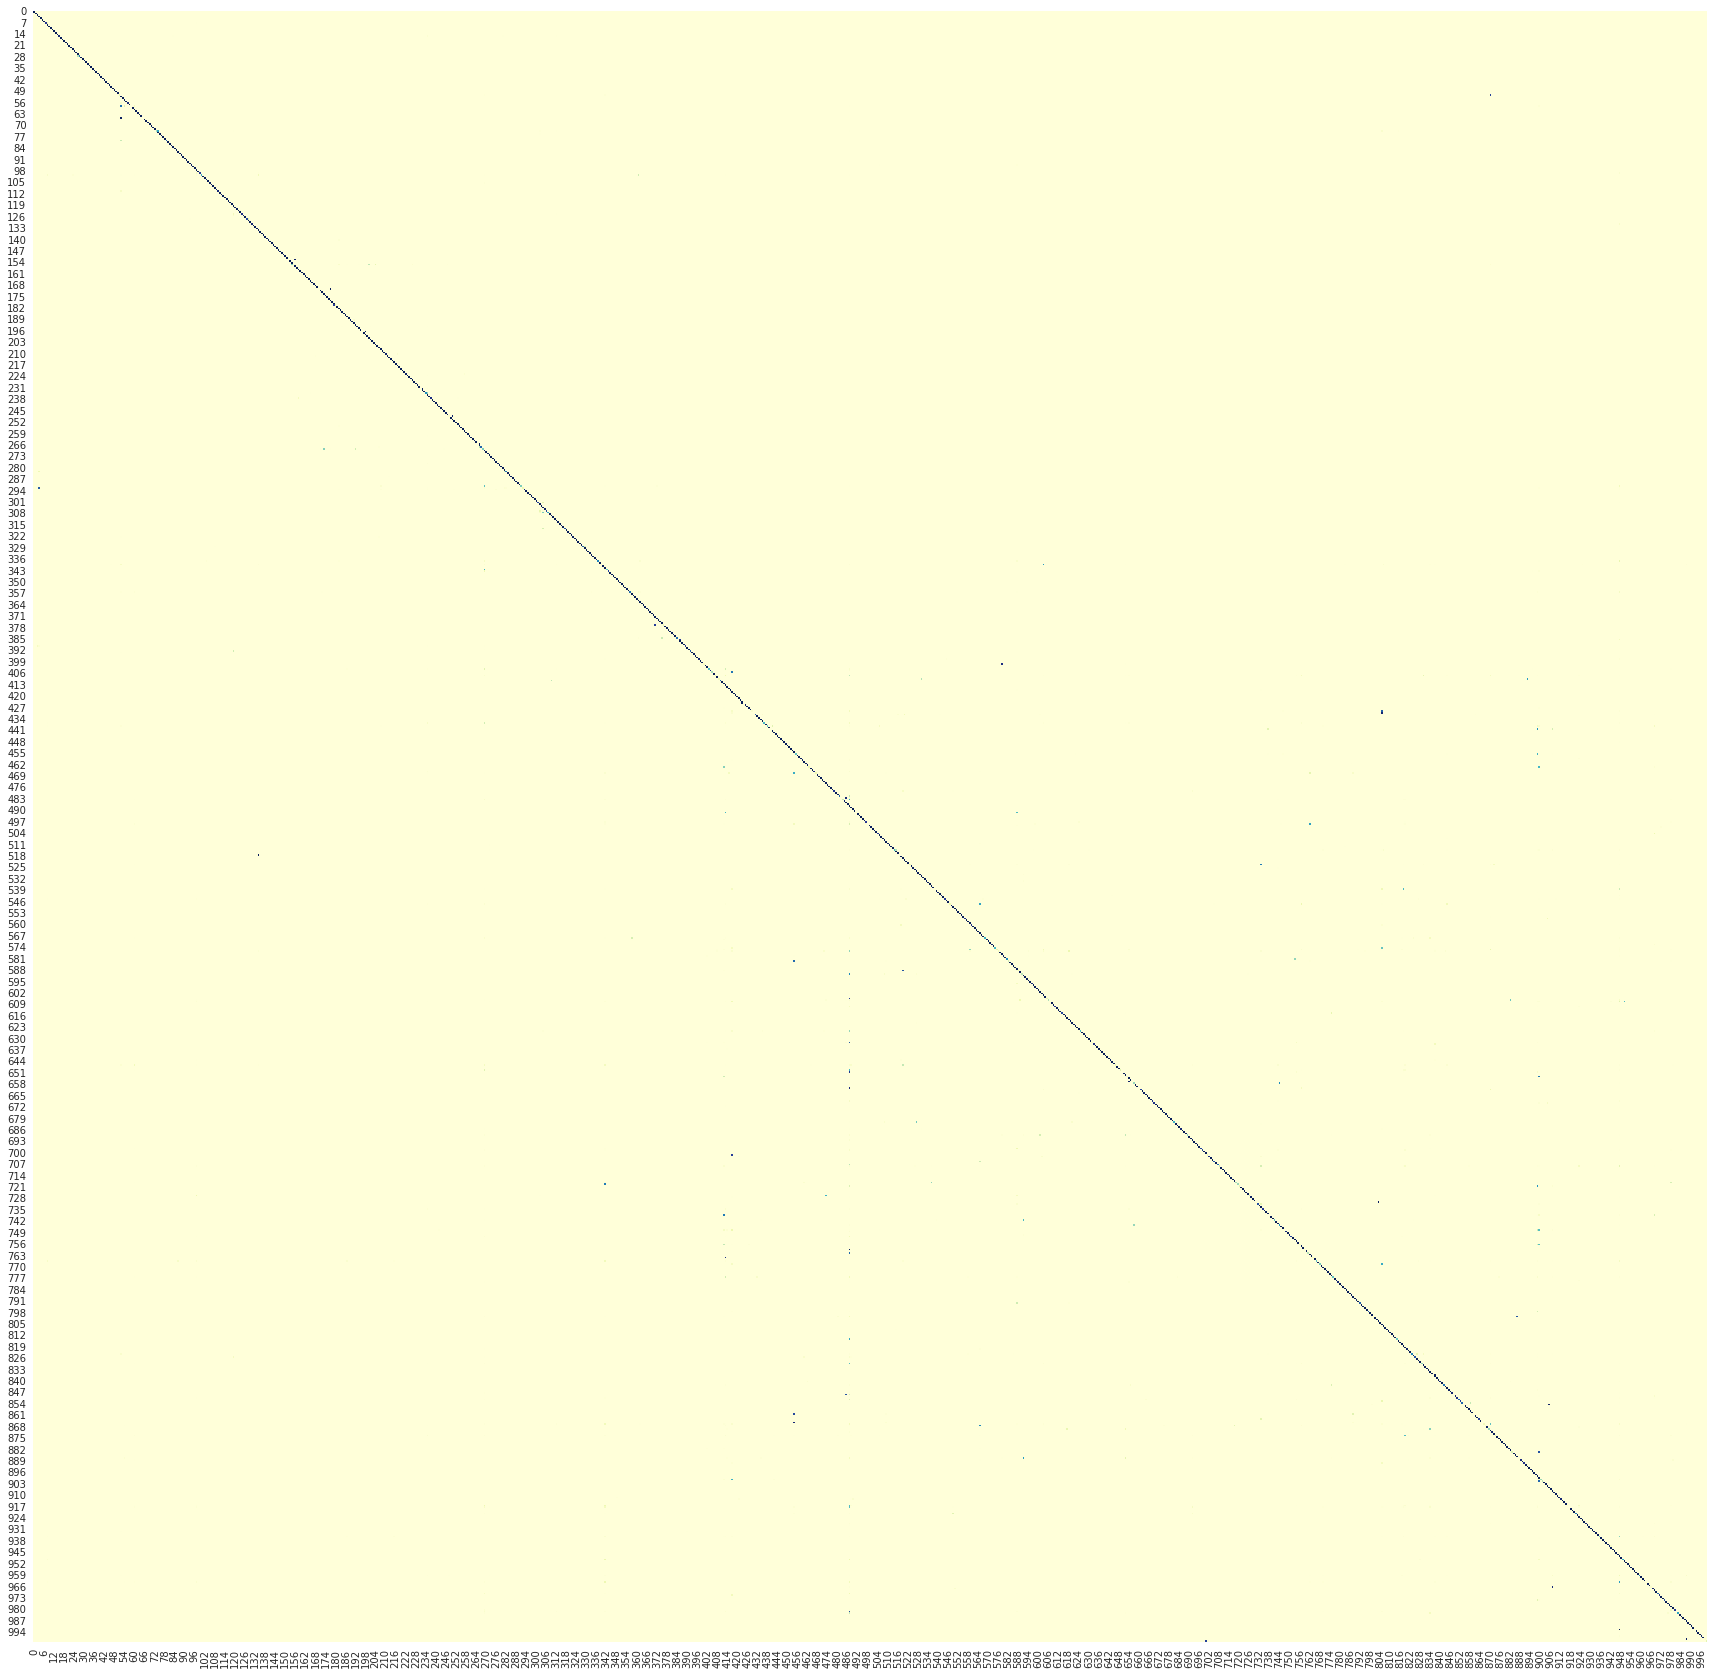

In [51]:
sns.heatmap(preds_text_proba, cmap="YlGnBu", cbar=False)
plt.show()

In [52]:
top_k_accuracy_score(text_labels, preds_text_proba, k=1)

0.909

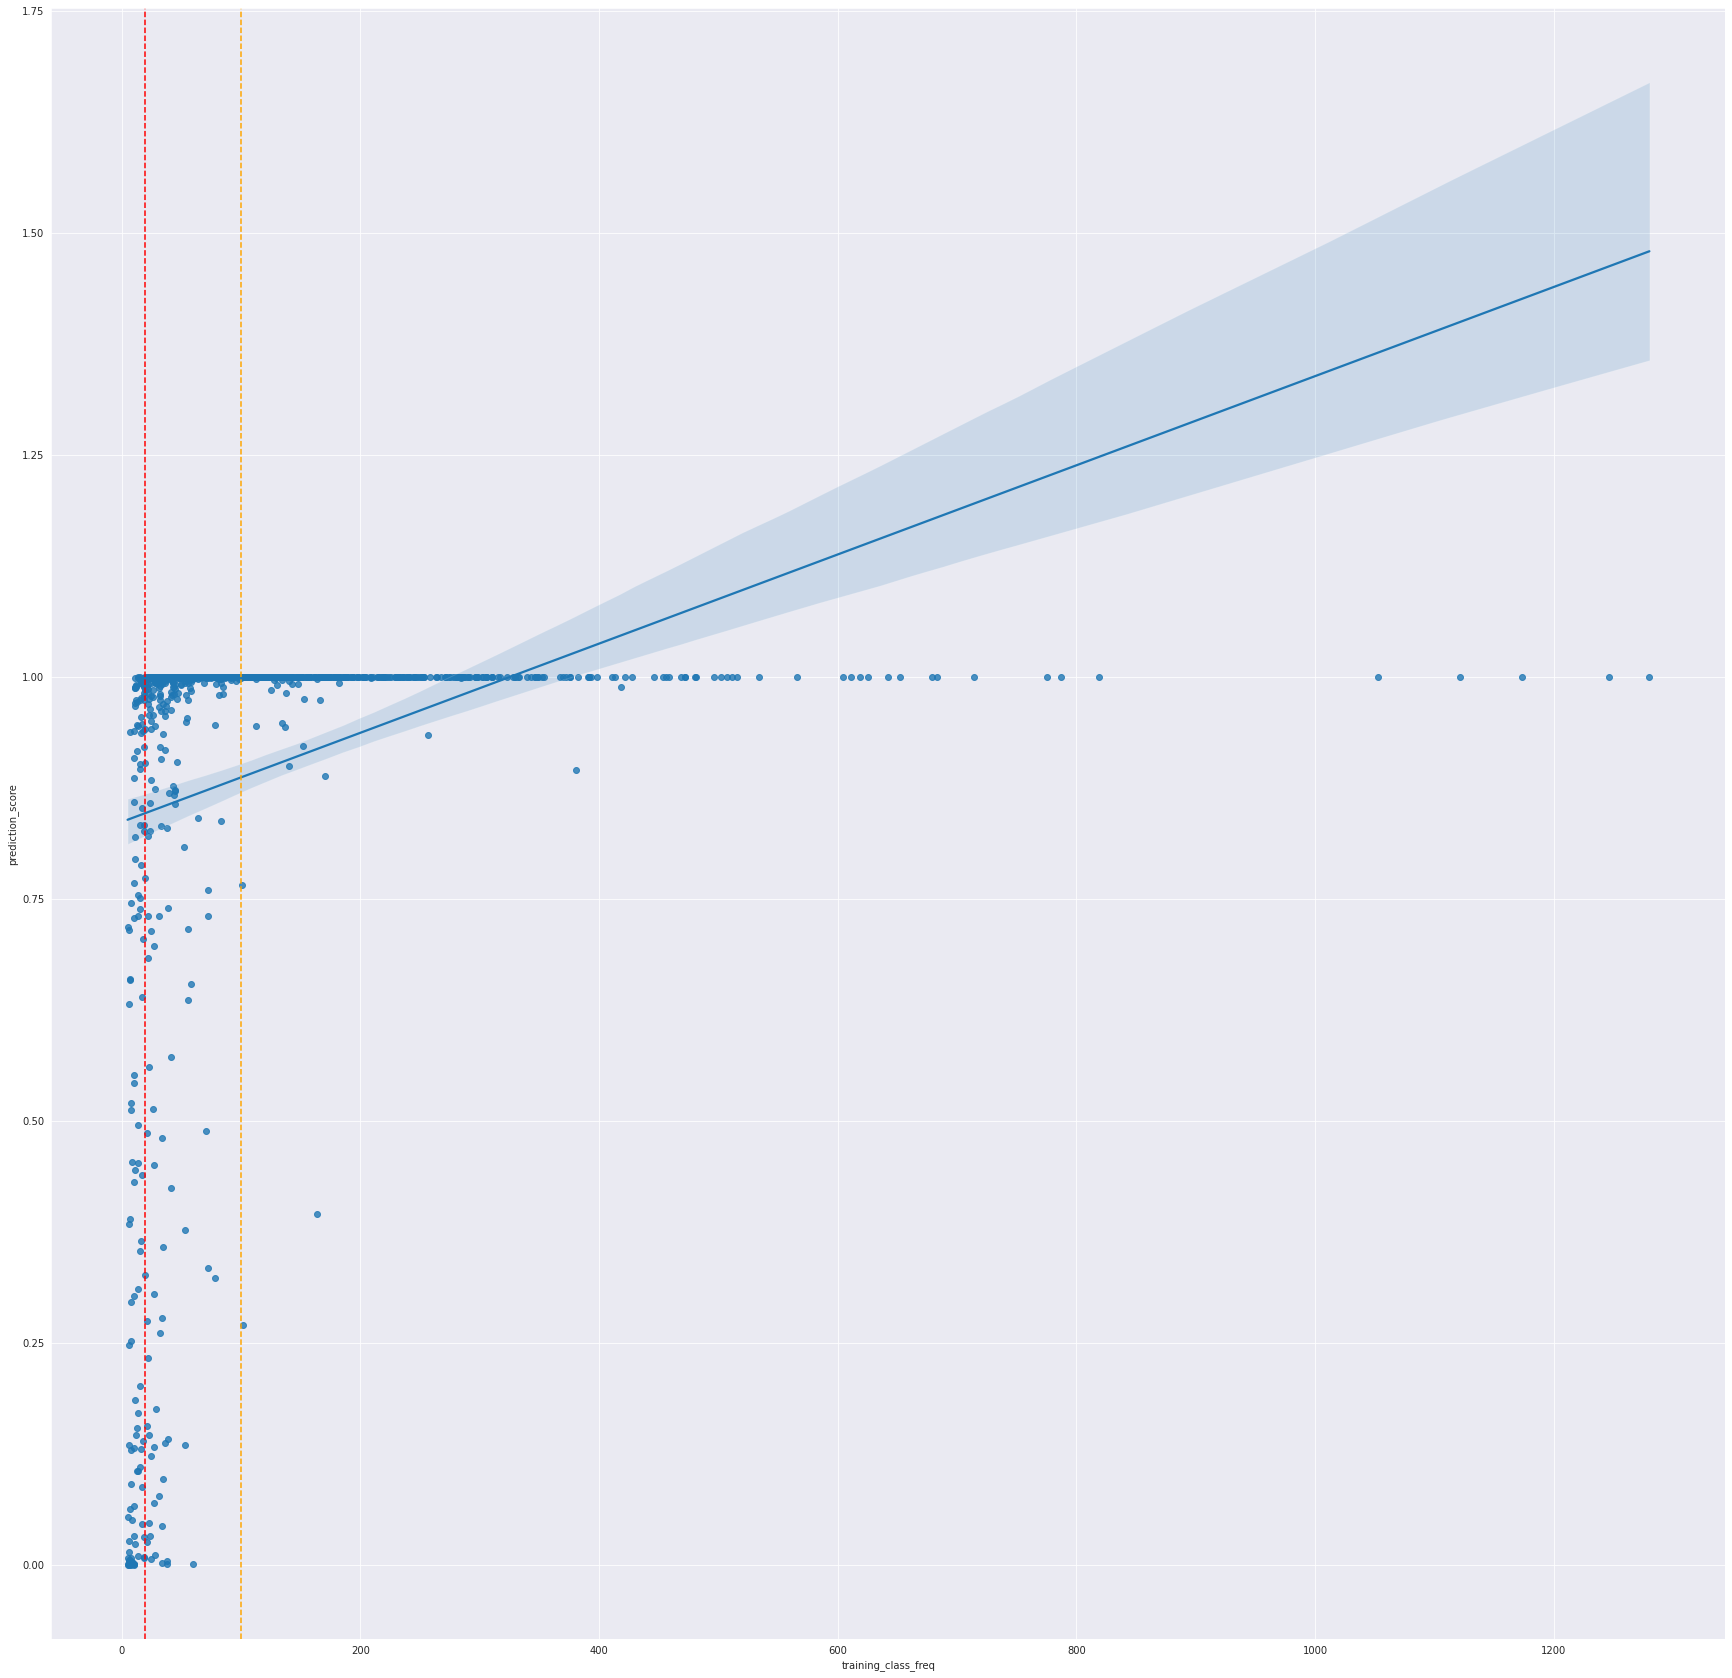

In [53]:
# Correlation between class frequency and text accuracy

import matplotlib.ticker as ticker

sns.set_style("darkgrid")

y = [preds_text_proba[l,l] for l in text_labels]
x = [freqs[l] for l in text_labels]

df = pd.DataFrame()
df["prediction_score"] = y
df["training_class_freq"] = x

graph = sns.regplot(data = df, x = "training_class_freq", y = "prediction_score")
graph.axvline(100, c="orange", linestyle="--")
graph.axvline(20, c="r", linestyle="--")

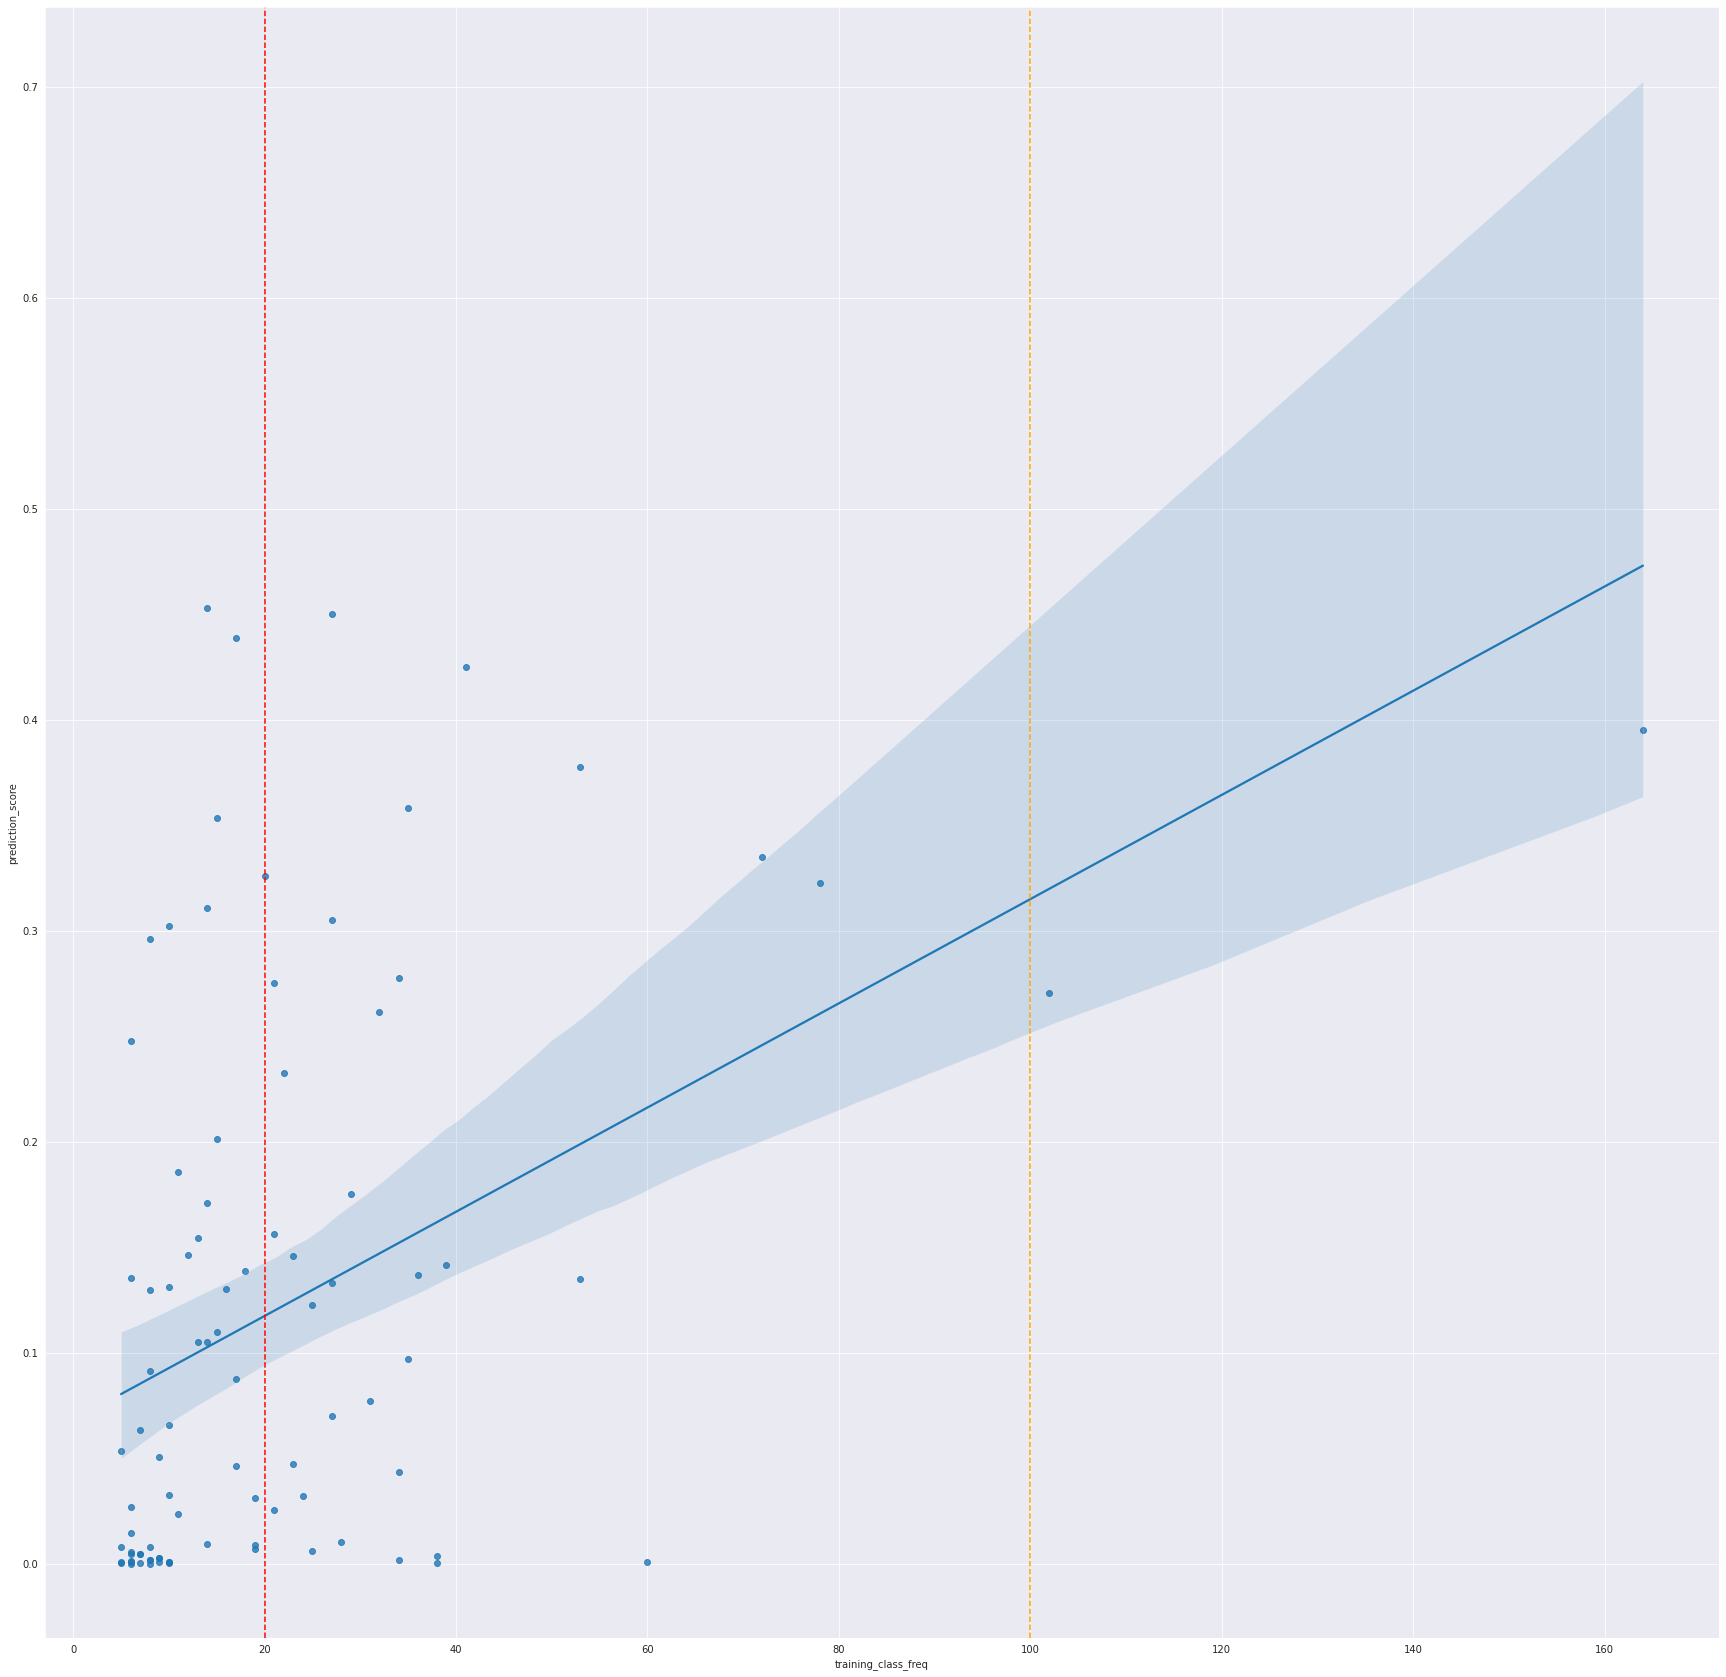

In [54]:
# Correlation between class frequency and text accuracy for incorrect samples

import matplotlib.ticker as ticker

sns.set_style("darkgrid")

y = np.array([preds_text_proba[l,l] for l in text_labels])
x = np.array([freqs[l] for l in text_labels])

inds = np.where(preds_text != text_labels)
y = y[inds]
x = x[inds]

df = pd.DataFrame()
df["prediction_score"] = y
df["training_class_freq"] = x

graph = sns.regplot(data = df, x = "training_class_freq", y = "prediction_score")
graph.axvline(100, c="orange", linestyle="--")
graph.axvline(20, c="r", linestyle="--")

In [55]:
# Understanding outliers

y = np.array([preds_text_proba[l,l] for l in text_labels])
x = np.array([freqs[l] for l in text_labels])
mask = preds_text != text_labels

outliers = []
for i in range(len(x)):
    
    if x[i] > 40:
        if mask[i] == True:
            outliers.append(i)
outliers

[291, 292, 657, 719, 768, 814, 836, 901]

In [56]:
for i in outliers:
    print("Correct:", CLASSES[text_labels[i]])
    print("Training Freq:", x[i])
#     print("Predicted:", CLASSES[preds_text[i]])
    inds = np.array((-preds_text_proba[i]).argsort()[:3])
    print("Predicted top 3:",np.array(CLASSES)[inds])
    print("Predicted top 3 prob:",preds_text_proba[i][inds])
    print("-------------")

Correct: lion
Training Freq: 53
Predicted top 3: ['grey wolf' 'lion' 'mushroom']
Predicted top 3 prob: [0.44594173 0.37760857 0.09185849]
-------------
Correct: tiger
Training Freq: 53
Predicted top 3: ['tiger shark' 'tiger' 'grey wolf']
Predicted top 3 prob: [0.7577292  0.13521528 0.02855057]
-------------
Correct: missile
Training Freq: 72
Predicted top 3: ['missile' 'missile' 'mobile phone']
Predicted top 3 prob: [0.63602124 0.3348065  0.01187539]
-------------
Correct: piggy bank
Training Freq: 78
Predicted top 3: ['pig' 'piggy bank' 'water jug']
Predicted top 3 prob: [6.76708409e-01 3.22596415e-01 2.00536083e-04]
-------------
Correct: rugby ball
Training Freq: 164
Predicted top 3: ['soccer ball' 'rugby ball' 'balloon']
Predicted top 3 prob: [0.53718628 0.39523327 0.06663741]
-------------
Correct: motorboat
Training Freq: 41
Predicted top 3: ['mobile phone' 'motorboat' 'amphibious vehicle']
Predicted top 3 prob: [0.54923541 0.42486627 0.00281839]
-------------
Correct: sunglasses

### Image Bias?

In [57]:
preds_im_proba = clf.predict_proba(image_embeddings.cpu())
preds_im = clf.predict(image_embeddings.cpu())

In [58]:
preds_im_proba_avg = np.zeros((1000,1000))
for i in range(50000):
    indx = labels[i]
    vals = preds_im_proba[i]
    preds_im_proba_avg[indx] += vals
    
preds_im_proba_avg /=50

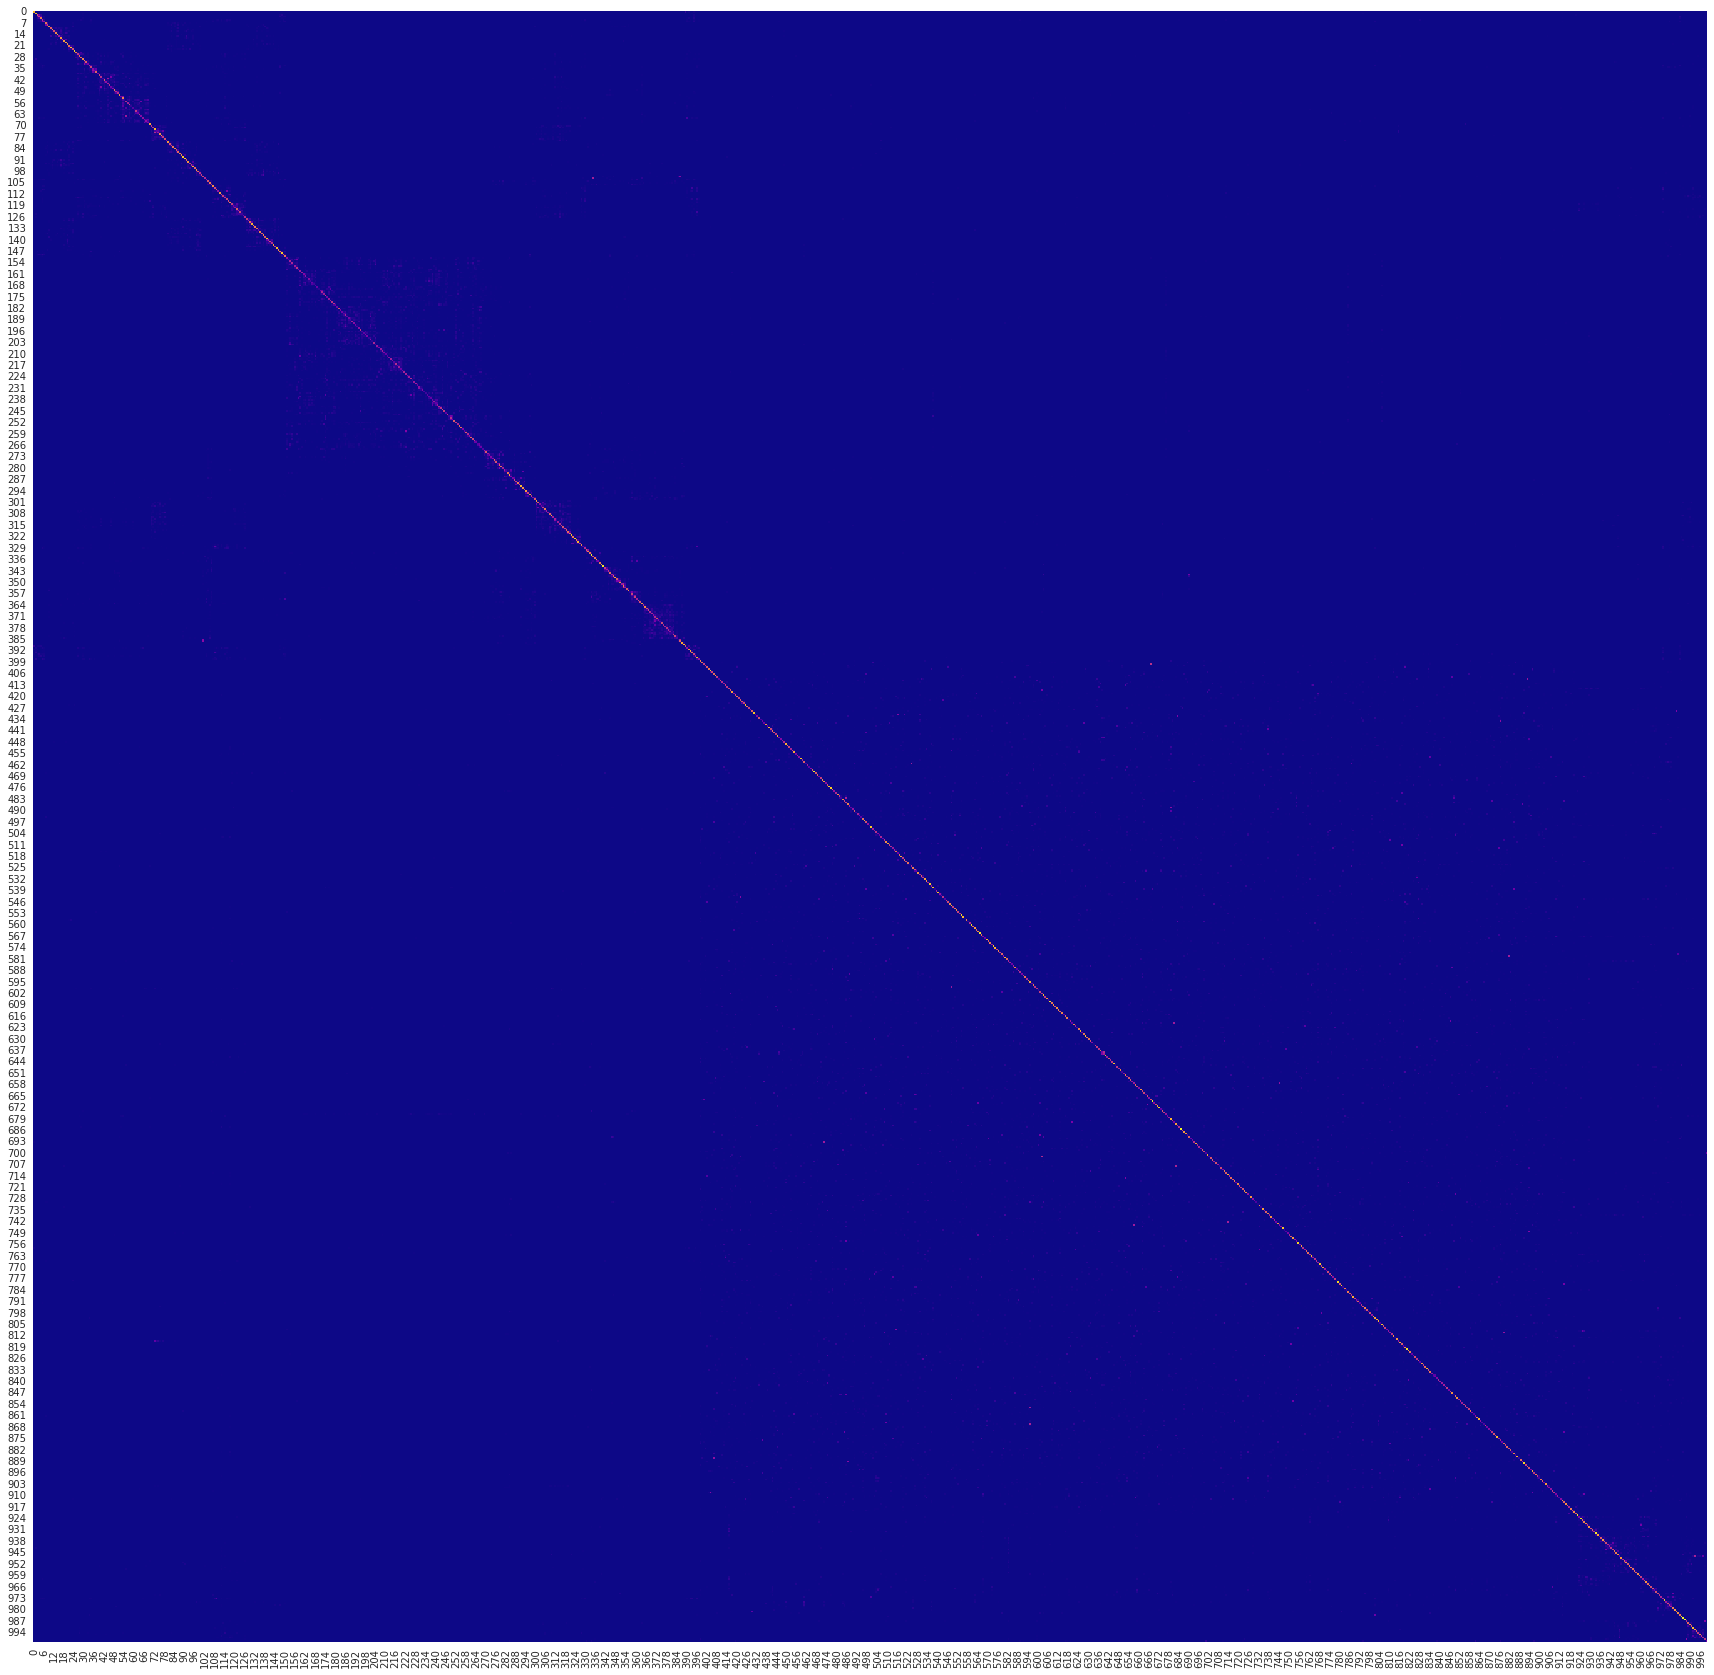

In [59]:
sns.heatmap(preds_im_proba_avg, cmap="plasma", cbar=False)
plt.show()

In [60]:
top_k_accuracy_score(labels, preds_im_proba, k=1)

0.62202

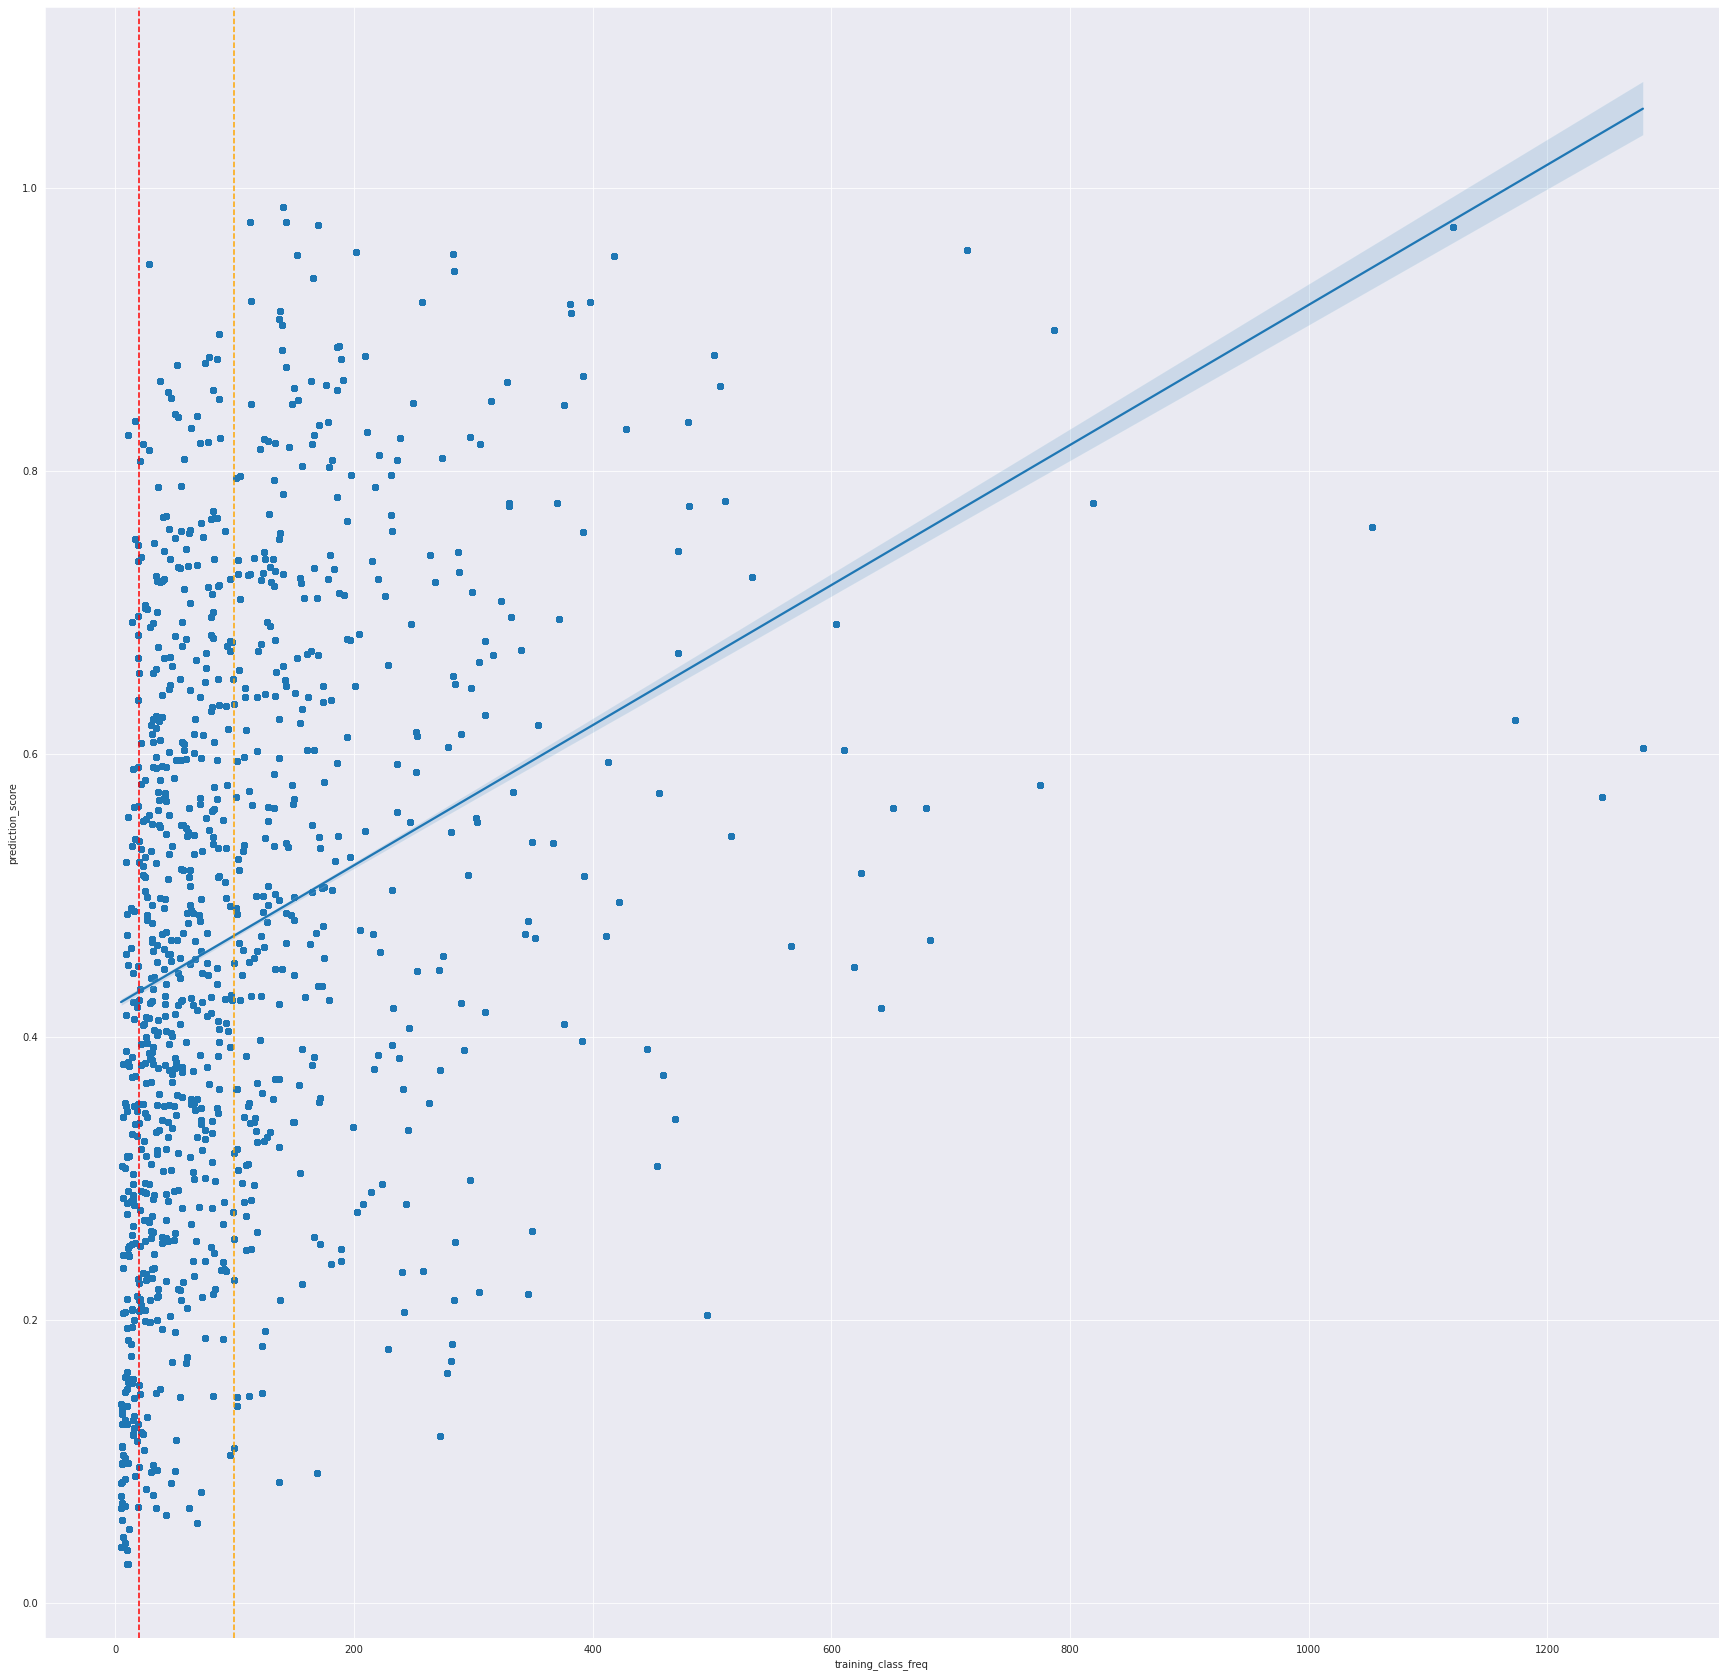

In [61]:
# Correlation between class frequency and image accuracy

import matplotlib.ticker as ticker

sns.set_style("darkgrid")

y = [preds_im_proba_avg[l,l] for l in labels]
x = [freqs[l.item()] for l in labels]

df = pd.DataFrame()
df["prediction_score"] = y
df["training_class_freq"] = x

graph = sns.regplot(data = df, x = "training_class_freq", y = "prediction_score")
graph.axvline(100, c="orange", linestyle="--")
graph.axvline(20, c="r", linestyle="--")

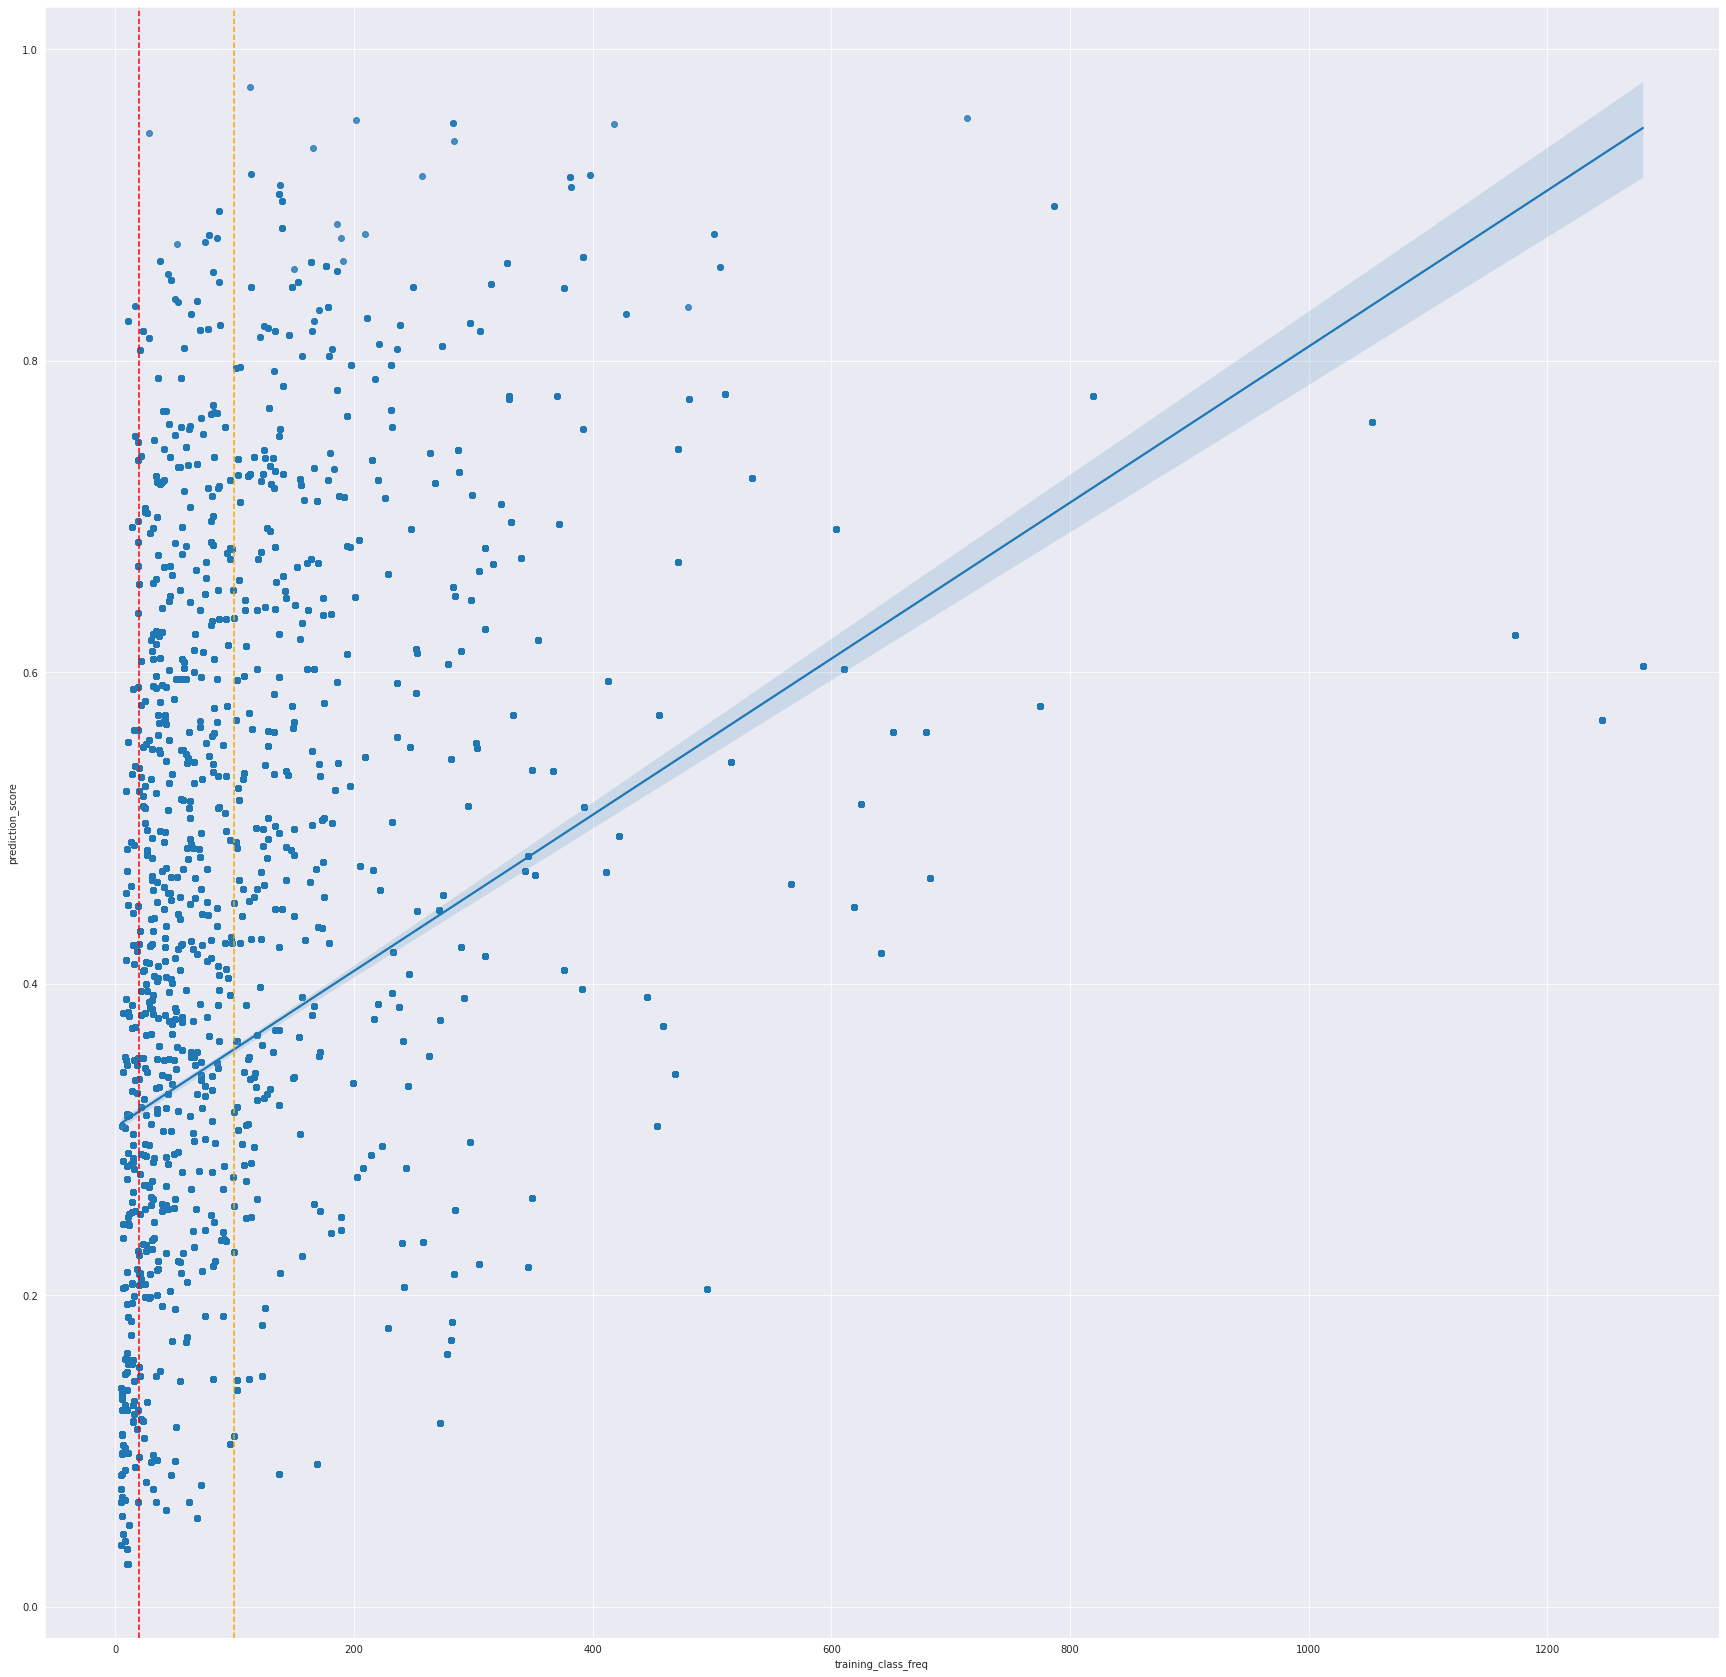

In [62]:
# Correlation between class frequency and text accuracy for incorrect samples

import matplotlib.ticker as ticker

sns.set_style("darkgrid")

y = np.array([preds_im_proba_avg[l,l] for l in labels])
x = np.array([freqs[l.item()] for l in labels])

inds = np.where(np.not_equal(preds_im,labels))
y = y[inds]
x = x[inds]

df = pd.DataFrame()
df["prediction_score"] = y
df["training_class_freq"] = x

graph = sns.regplot(data = df, x = "training_class_freq", y = "prediction_score")
graph.axvline(100, c="orange", linestyle="--")
graph.axvline(20, c="r", linestyle="--")

### Add closest text at eval time

In [65]:
# Pairwise cosine similarity between image and text 
import sklearn 
pairwise_cs = sklearn.metrics.pairwise.cosine_similarity(image_embeddings.cpu(), text_embs.cpu())
pairwise_cs = normalize(pairwise_cs, axis=1, norm='l1')
pairwise_cs.shape

(50000, 1000)

In [66]:
# add to the most similar text

indices = np.argmax(pairwise_cs, axis=-1)
most_similar_text = np.take_along_axis(text_embs.cpu(), indices[:,None], axis=0)
print(most_similar_text.shape)

conv_comb_test = 0.8*(image_embeddings.cpu()) + 0.2*(most_similar_text)
predictions_conv_comb_test = clf.predict(conv_comb_test)
avg_acc = mic_acc_cal(predictions_conv_comb_test, labels.numpy())
print(avg_acc)

torch.Size([50000, 1024])
0.59572


In [85]:
# add to the top k similar text

def conv_comb_top_k_similar(k):
    indices = (-pairwise_cs).argsort(axis=-1)[:, :k]
#     indices = np.argmax(pairwise_cs, axis=-1)
    most_similar_texts = []
    for i in tqdm(range(50000)):
        instance_indices = indices[i]
        most_similar_text = np.take_along_axis(text_embs.cpu(), instance_indices[:,None], axis=0)
        most_similar_text = torch.mean(most_similar_text,axis=0)
        most_similar_texts.append(most_similar_text)
    most_similar_texts = torch.stack(most_similar_texts)

    conv_comb_test = 0.8*(image_embeddings.cpu()) + 0.2*(most_similar_texts)
    predictions_conv_comb_test = clf.predict(conv_comb_test)
    avg_acc = mic_acc_cal(predictions_conv_comb_test, labels.numpy())
    return avg_acc
    
for i in reversed(range(1, 1000, 50)):
    acc = conv_comb_top_k_similar(i)
    print(f"K: {i}, Acc: {acc}")

  0%|          | 0/50000 [00:00<?, ?it/s]

K: 951, Acc: 0.60676


  0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# add to the top k similar text weighted by relative similarity

def conv_comb_top_k_similar_weighted(k):
    indices = (-pairwise_cs).argsort(axis=-1)[:, :k]
#     indices = np.argmax(pairwise_cs, axis=-1)
    most_similar_texts = []
    for i in tqdm(range(50000)):
        instance_indices = indices[i]
        most_similar_text = np.take_along_axis(text_embs.cpu(), instance_indices[:,None], axis=0)
        weights = pairwise_cs[i, instance_indices]
        weights = weights/weights.sum()
        most_similar_text = np.dot(most_similar_text.T, weights)
        most_similar_texts.append(most_similar_text)
    most_similar_texts = np.stack(most_similar_texts)
#     print(most_similar_texts.shape)

    conv_comb_test = 0.8*(image_embeddings.cpu()) + 0.2*(most_similar_texts)
    predictions_conv_comb_test = clf.predict(conv_comb_test)
    avg_acc = mic_acc_cal(predictions_conv_comb_test, labels.numpy())
    return avg_acc
    
for i in reversed(range(1, 1000, 50)):
    acc = conv_comb_top_k_similar_weighted(i)
    print(f"K: {i}, Acc: {acc}")

  0%|          | 0/50000 [00:00<?, ?it/s]

K: 951, Acc: 0.60666


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 901, Acc: 0.60616


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 851, Acc: 0.6058


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 801, Acc: 0.6054


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 751, Acc: 0.6052


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 701, Acc: 0.60496


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 651, Acc: 0.60474


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 601, Acc: 0.60452


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 551, Acc: 0.60474


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 501, Acc: 0.60432


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 451, Acc: 0.6046


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 401, Acc: 0.60494


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 351, Acc: 0.60546


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 301, Acc: 0.60614


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 251, Acc: 0.60652


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 201, Acc: 0.60702


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 151, Acc: 0.60774


  0%|          | 0/50000 [00:00<?, ?it/s]

### Add closest text at eval time - Synonyms